In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj, get_p_x4_short_time
from setup import setup_matplotlib

setup_matplotlib()

np.random.seed(42)

In [3]:
k = 1
s = 1
D = s**2/2
N_t = 100
ntau = 3
dx = 0.2
sb = 20*dx

f = 15
N_p = 16_000


x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

def force(x,*args):
     return -k*x**3

i_zero = np.argmin(x_s**2)

# Deterministic system

In [4]:
det_f = 200
x = np.empty(100000)


def get_con(x0, ntau_t, dt_t ):
    x[:ntau_t] = 0
    x[ntau_t-1] = x0
    for i in range(ntau_t, len(x)):
        x[i] = x[i-1]+force(x[i-ntau_t])*dt_t
    return np.isfinite(x[-1]) and x[-1] < x0


det_ltaus = np.logspace(-2,1,20) #np.arange(0.01,0.21,0.01)
diff_b = []


for ltau in det_ltaus:
    x1 = 0.001
    x3 = 60
    
    ntau_t = ntau*det_f
    dt_t = ltau/ntau_t
    
    e1 = get_con(x1, ntau_t, dt_t)
    e3 = get_con(x3, ntau_t, dt_t)
    if not e1 or e3:
        print('Boundarys to small')
    for i in range(10):
        x2 = (x1+x3)/2
        e2 = get_con(x2, ntau_t, dt_t)
        if e2:
            x1 = x2
        else:
            x3 = x2
    diff_b.append((x1+x3)/2)

/tmp/ipykernel_36333/84168098.py:18: RuntimeWarning: overflow encountered in double_scalars
  return -k*x**3
/tmp/ipykernel_36333/2063624341.py:9: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = x[i-1]+force(x[i-ntau_t])*dt_t


Text(0.5, 0, '$\\tau$')

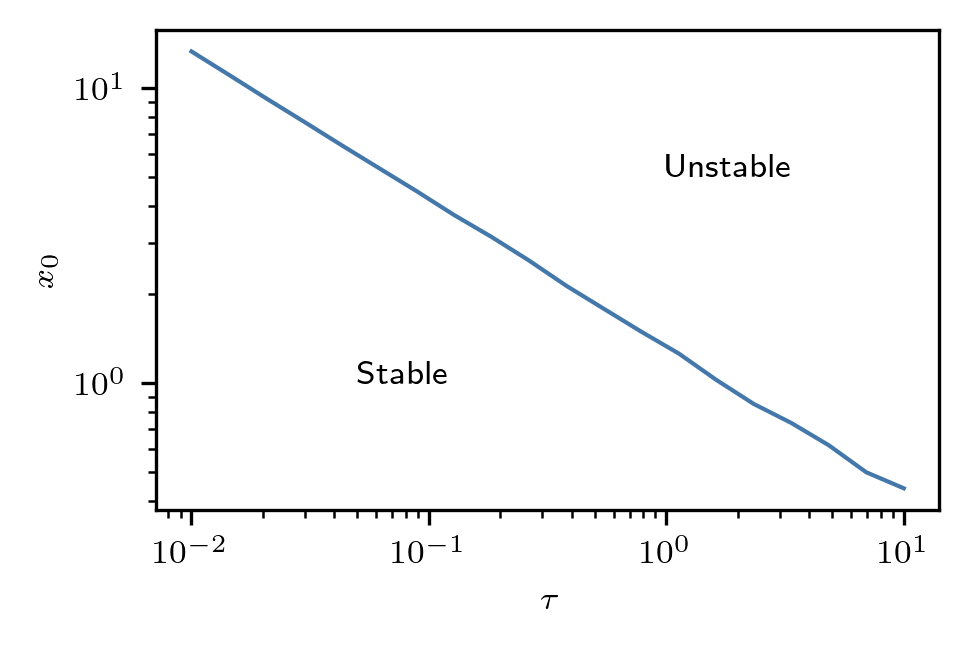

In [5]:
plt.plot(det_ltaus, diff_b)
#plt.plot(ltaus, 4/3*ltaus**(-1/2)) #Why ??
plt.text(1,5,'Unstable')
plt.text(0.05,1,'Stable')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$x_0$')
plt.xlabel(r'$\tau$')

# Stochastic system

In [6]:
ltaus = np.concatenate(([0.05], np.arange(0.1,1.1,0.1) ))
sim_vars = np.empty(len(ltaus))
num_vars = np.empty(len(ltaus))
sim_hist_vars = np.empty(len(ltaus))
short_time_approx_var = np.empty(len(ltaus))
escaped_traj = np.empty(len(ltaus))

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx, side = 'lr')
    R, _, end_states = create_R_v1(N_x, ntau, prop)
    
    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=ldt/f,border=0, force=force)
    all_pos = pos[0]
    sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]), leave=False)]
 
    sim_var = np.var(pos, axis = 1) # Use only particles which are not on a diverging traj
    sim_hist_var = get_var_hist(sim_hists, x_s)
    
    num_var = get_var_hist(hists, x_s)
    
    short_time_p = get_p_x4_short_time(x_s, k,ltau,s)

    
    escaped_traj[i] = 1-np.sum(sim_hists[-1])/N_p
    sim_vars[i] = np.mean(sim_var[0,-(f*N_t)//2:])
    num_vars[i] = np.mean(num_var[-N_t//2:])
    sim_hist_vars[i] = np.mean(sim_hist_var[-f*N_t//2:])
    short_time_approx_var[i] = get_var_hist(short_time_p, x_s)

    
# with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}_x4.pkl', 'wb') as file:
#     pickle.dump({'ltaus':ltaus,
#                  'sim_vars':sim_vars,
#                  'sim_hist_vars':sim_hist_vars,
#                  'num_vars':num_vars
#                 }, file)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

/tmp/ipykernel_36333/84168098.py:18: RuntimeWarning: overflow encountered in power
  return -k*x**3
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/paper/functions.py:136: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt


  0%|          | 0/1575 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1529 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

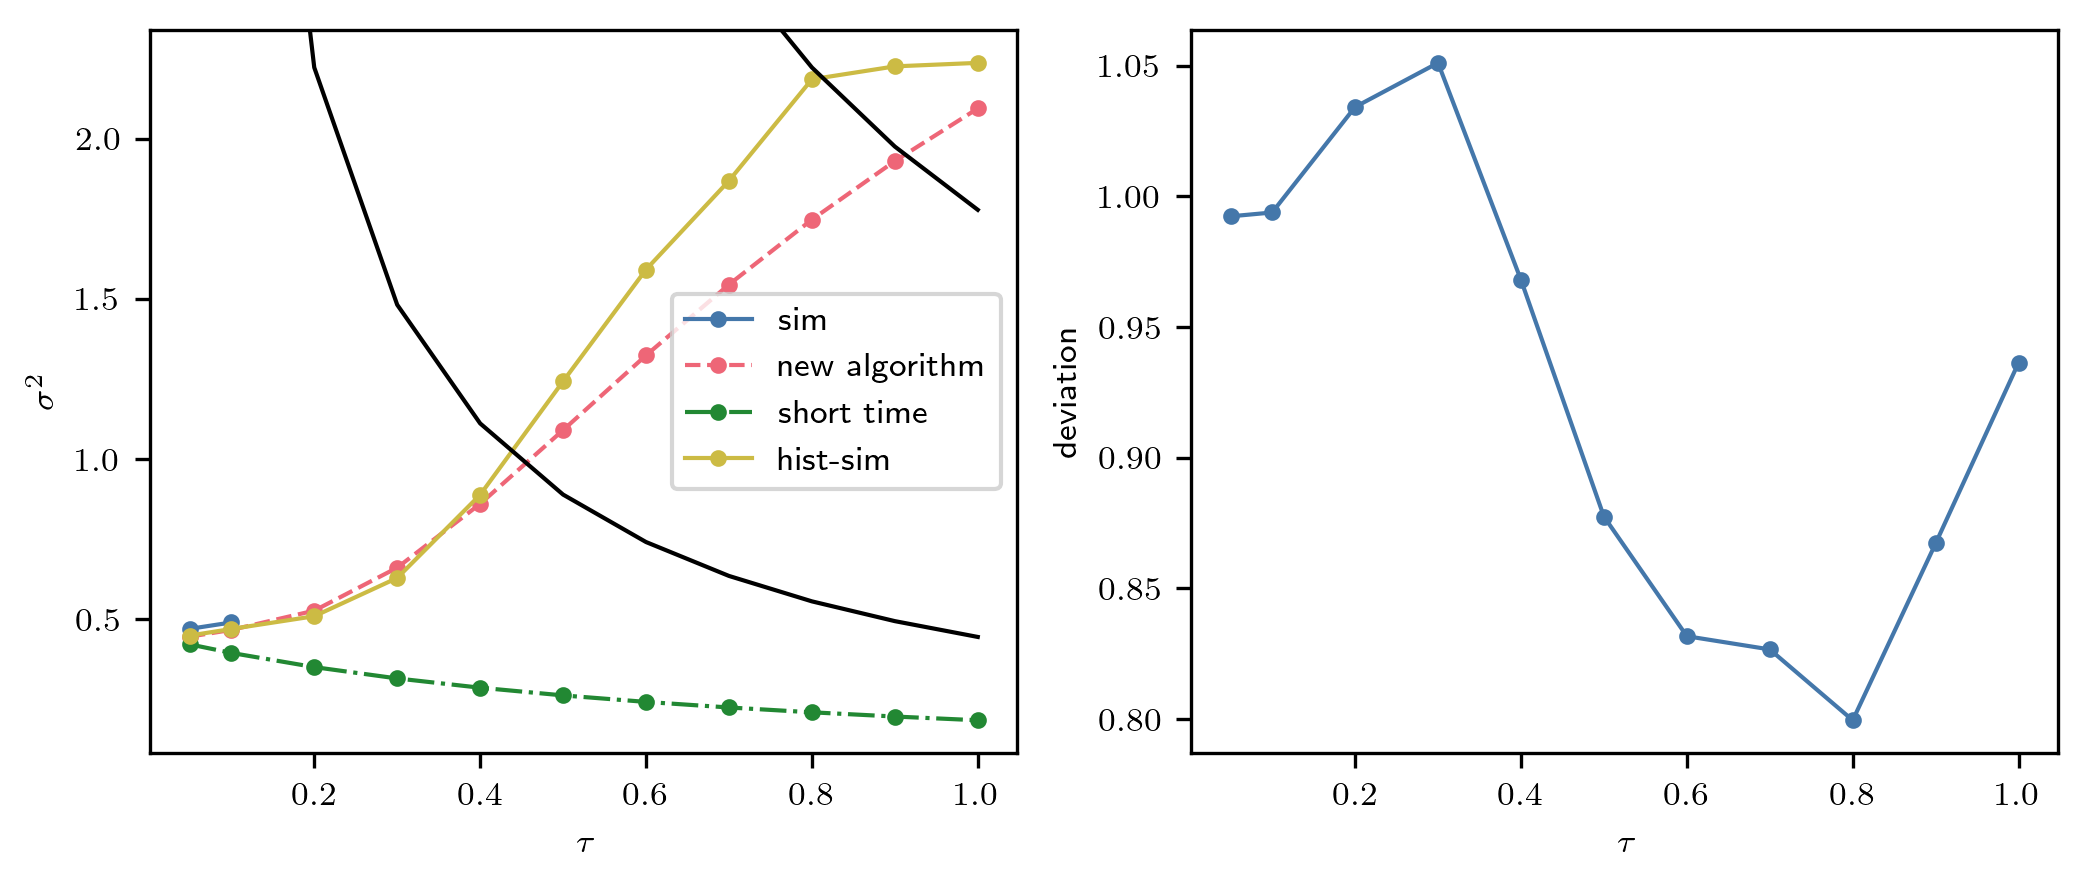

In [9]:
plt.figure(figsize=(7,3))
ax = plt.subplot(121)
plt.plot(ltaus,sim_vars,'.-', label='sim')

plt.plot(ltaus,num_vars,'.--', label='new algorithm')



plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')

plt.plot(ltaus,sim_hist_vars,'.-', label='hist-sim')

#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.ylim(*plt.ylim())
#auflösungslimit std same as div x0
plt.plot(ltaus, (2/3)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus, (4/3)**2*ltaus**(-1), color = 'black')

ax = plt.subplot(122)
plt.plot(ltaus, num_vars/sim_hist_vars, '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')

plt.tight_layout()
plt.savefig('graphics/x4variance.pdf')

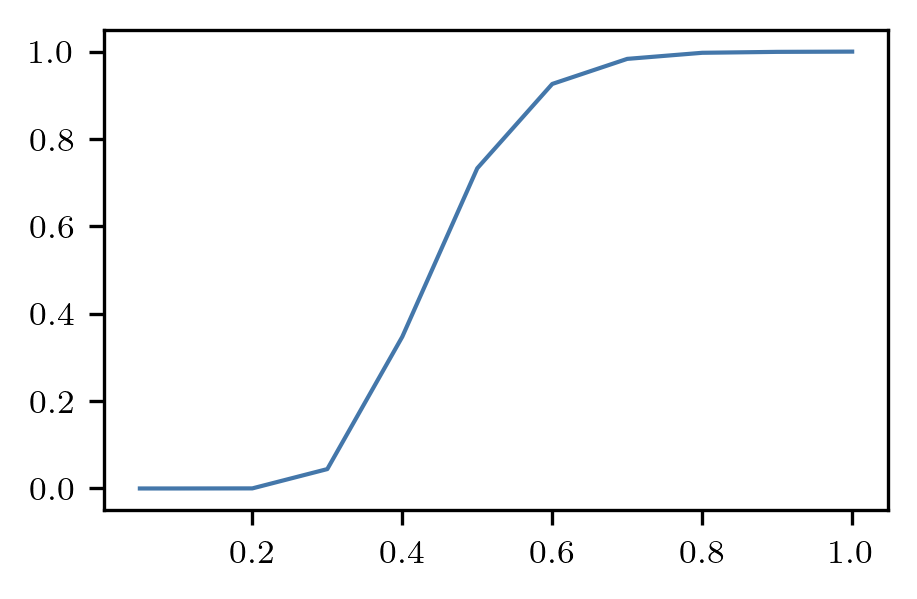

In [10]:
#plt.ylim(0,2)
plt.plot(ltaus, escaped_traj)